In [1]:
!pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece
#CUDA_LAUNCH_BLOCKING=1
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 47.9 MB/s 
     |████████████████████████████████| 880 kB 67.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0ae60feae76a1845619c6007fdc6bc82be28d4573a88e10a6878ef7f475bfbf7
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
def get_sst_examples(input_file):
  """Creates examples for the training and dev sets."""
  examples = []

  with open(input_file, 'r') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      for line in file_as_list[1:]:
          split = line.split(" ")
          question = ' '.join(split[1:])

          text_a = question
          inn_split = split[0].split(":")
          label = inn_split[0] + "_" + inn_split[1]
          examples.append((text_a, label))
      f.close()

  return examples

In [ ]:
#Load the examples
#labeled_examples = get_sst_examples("sst_train.txt")
##unlabeled_examples = get_sst_examples("sst_dev.txt")
#test_examples = get_sst_examples("sst_test.txt")

In [ ]:
pip install pytreebank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pytreebank
import sys
import os

out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst('./raw_data')

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))
# Print the length of the training set
print(len(dataset['train']))

8544


In [ ]:
import pandas as pd

df_train_copy=pd.read_csv('sst_train.txt', sep='\t', header=None, names=['truth', 'text'])
df_test=pd.read_csv('sst_test.txt', sep='\t', header=None, names=['truth', 'text'])
df_dev_copy=pd.read_csv('sst_dev.txt', sep='\t', header=None, names=['truth', 'text'])

In [ ]:
df_all=df_train_copy.append(df_dev_copy, ignore_index=False)

In [ ]:
df_all

,truth,text
0,__label__4,The Rock is destined to be the 21st Century 's...
1,__label__5,The gorgeously elaborate continuation of `` Th...
2,__label__4,Singer/composer Bryan Adams contributes a slew...
3,__label__3,You 'd think by now America would have had eno...
4,__label__4,Yet the act is still charming here .
...,...,...
1096,__label__2,it seems to me the film is about the art of ri...
1097,__label__2,It 's just disappointingly superficial -- a mo...
1098,__label__2,The title not only describes its main characte...
1099,__label__3,Sometimes it feels as if it might have been ma...


In [ ]:
from sklearn.model_selection import train_test_split
df_train,df_dev=train_test_split(df_all, test_size=0.3, random_state=42)

In [ ]:
len(df_all)

9645

In [ ]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-5
learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 8
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

#model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "distilbert-base-cased"
#model_name = "roberta-base"
model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name = "prajjwal1/bert-tiny"

label_list = ["__label__1","__label__2", "__label__3", "__label__4", "__label__5"]
df_test['truth'][0]

'__label__3'

In [ ]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
print("Train:",len(df_train))
print("Test:",len(df_test))
print("Dev:",len(df_dev))

Train: 6751
Test: 2210
Dev: 2894


In [ ]:
df_dev['truth'].iloc[0]

'__label__2'

In [ ]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i

In [ ]:
label_map

{'__label__1': 0,
 '__label__2': 1,
 '__label__3': 2,
 '__label__4': 3,
 '__label__5': 4}

In [ ]:
def convert(df):

  l=[]
  for i in range(len(df)):
    l.append((df['text'].iloc[i],df['truth'].iloc[i]))

  return l



In [ ]:
#for i in range(len(df_train)):
  #print(df_train['text'][i])
labeled_examples = convert(df_dev)
unlabeled_examples = convert(df_train)
test_examples = convert(df_test)

In [ ]:

#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
if unlabeled_examples:
  train_examples = train_examples + unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [ ]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [ ]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

In [ ]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)

        real_batch_size = b_input_ids.shape[0]
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        gen_rep = generator(noise)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )


======== Epoch 1 / 8 ========
Training...
  Batch    10  of    151.    Elapsed: 0:00:11.
  Batch    20  of    151.    Elapsed: 0:00:22.
  Batch    30  of    151.    Elapsed: 0:00:33.
  Batch    40  of    151.    Elapsed: 0:00:44.
  Batch    50  of    151.    Elapsed: 0:00:55.
  Batch    60  of    151.    Elapsed: 0:01:06.
  Batch    70  of    151.    Elapsed: 0:01:17.
  Batch    80  of    151.    Elapsed: 0:01:28.
  Batch    90  of    151.    Elapsed: 0:01:39.
  Batch   100  of    151.    Elapsed: 0:01:50.
  Batch   110  of    151.    Elapsed: 0:02:01.
  Batch   120  of    151.    Elapsed: 0:02:12.
  Batch   130  of    151.    Elapsed: 0:02:23.
  Batch   140  of    151.    Elapsed: 0:02:34.
  Batch   150  of    151.    Elapsed: 0:02:45.

  Average training loss generetor: 0.682
  Average training loss discriminator: 2.343
  Training epcoh took: 0:02:46

Running Test...
  Accuracy: 0.396
  Test Loss: 1.378
  Test took: 0:00:09

======== Epoch 2 / 8 ========
Training...
  Batch    10  o

In [1]:
## The values here have been written down due to gpu constraints as all models could not be run in a single session

import matplotlib.pyplot as plt

xaxis=[1,2,5,10,20,30,40,50]
ybert=[0.337,0.357,0.421,0.433,0.441,0.479,0.481,0.508]
yrobert=[0.176,0.176,0.231,0.231,0.231,0.231,0.231,0.231]
yalbert=[0.176,0.286,0.386,0.404,0.433,0.475,0.481,0.513]
ytiny=[0.144,0.252,0.327,0.395,0.411,0.429,0.461,0.494]

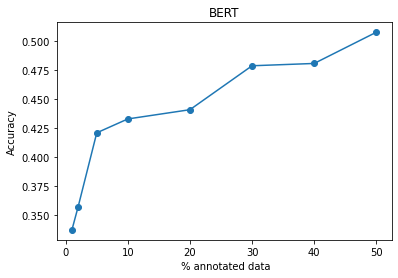

In [2]:
plt.plot(xaxis, ybert, '-o')
plt.xlabel(" % annotated data")
plt.ylabel("Accuracy")
plt.title("BERT")
plt.show()

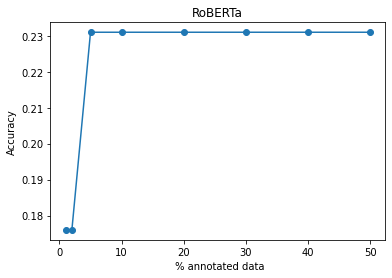

In [3]:
plt.plot(xaxis, yrobert, '-o')
plt.xlabel(" % annotated data")
plt.ylabel("Accuracy")
plt.title("RoBERTa")
plt.show()

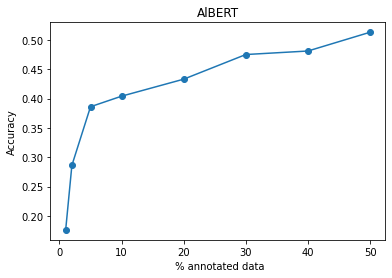

In [4]:
plt.plot(xaxis, yalbert, '-o')
plt.xlabel(" % annotated data")
plt.ylabel("Accuracy")
plt.title("AlBERT")
plt.show()

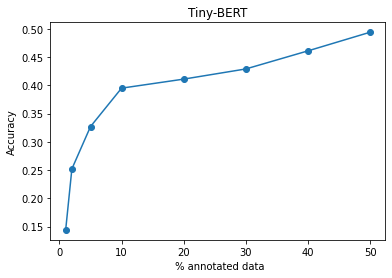

In [2]:
plt.plot(xaxis, ytiny, '-o')
plt.xlabel(" % annotated data")
plt.ylabel("Accuracy")
plt.title("Tiny-BERT")
plt.show()

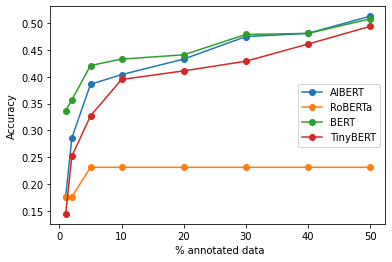

In [11]:
plt.plot(xaxis, yalbert, '-o',label='AlBERT')
plt.plot(xaxis, yrobert, '-o',label='RoBERTa')
plt.plot(xaxis, ybert, '-o',label='BERT')
plt.plot(xaxis, ytiny, '-o',label='TinyBERT')
plt.xlabel(" % annotated data")
plt.ylabel("Accuracy")
plt.legend()
plt.show()